#  Variational Quantum Algorithm

We know that Quantum algorithams like amplitude amplification and linear algebra routines are dependent on fault-tolerant
quantum computations which are based on a large number of qubits or we can say that they are not suitable for the existing
quantum computers.
As a comeback, we have a new class of algorithams known as variational quantum algorithams.
The name 'variational' comes from the fact that we can tune the parameters of the gates and those parameters can be chosen 
from the optimisation of cost function defined on that problem classicaly.

#### Introducing two important examples of variational Quantum algoritham 
- Variational Quantum Eigensolver or VQE
- quantum approximate optimisation algorithm or QAOA

### Variational Quantum Eigensolver

variational algorithams can be used to calculate ground state (lowest energy eigenstates) of quantum systems. Variational principle: It tells us that the ground state $|\psi\rangle$ minimizes the expectation value of the Hamiltonian of a system.

The idea of utilising Variational Quantum Eigensolver is that we use a parametrized ansatz $W(\theta)$ to prepare our state $W(\theta) = |\psi\rangle $. We find the parameters that minimizes the expectation value. 
So, Basically we use the expectation value of our Hamiltonian as a cost function in variational quantum algoritham. i.e $$ C(\theta) = \langle{\psi(\theta)}|H|\psi(\theta)\rangle $$

#### Principle of a variational quantum eigensolver

In the variational quantum eigensolver, the observable is the Hamiltonian of the system. For many problems of interest, the Hamiltonian decomposes into a linear combination of local Hamiltonian terms, which can be measured separately, and the expectations summed classically.
<img src="22.jpg" width="400" height="350">


Writting H as sum of local observables, 
$$ \large H = \sum_{j=1}^{J} h_jH_j $$
In terms of Pauli's Operators,
$$ \large H = \sum_{i=1}^{n} \sum_{\alpha \in \{x,y,z,1\}} h_\alpha^i \sigma_\alpha^i + \sum_{i,j=1}^{n} \sum_{\alpha,\beta \in \{x,y,z,1\}} h_{\alpha\beta}^{ij} \sigma_\alpha^i \sigma_\beta^j + \cdots $$

Therefore, the expectation value will become (the sum of expectations)
$$ \large \langle H\rangle = \sum_{i,\alpha} h_\alpha^i\langle \sigma_\alpha^i \rangle + \sum_{i,j\alpha,\beta}h_{\alpha,\beta}^{ij} \langle \sigma_\alpha^i \sigma_\beta^j \rangle+ \cdots  $$

Now, the overall cost function will be 
$$ \large C(\theta) = \sum_{j=1}^{J} h_j\langle \psi(\theta)|H_j|\psi(\theta) \rangle $$

Variational quantum eigensolvers minimise the expectation value of an observable of a system, here the Hamiltonian, using a hybrid classical-quantum algorithm (<u> <b> quantum part computes the energy and classical part optimizes the variational parameter </b> </u>) that linearly combines the results of different quantum measurements (given a single-circuit ansatz)

## Implementation in qiskit

We can use VQE to compute interatomic distances as interatomic distance is the one where the molecule has least energy. So we vary the distance between the molecules and calculate the energies at respective distances to check where it gets minimum.

In [ ]:
!pip install pyscf

In [ ]:
!pip install qiskit

In [11]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD #ansatz
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType # for mapping

In [7]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' 
distances = np.arange(0.5,4.25,0.25)
vqe_energies = []
hf_energies = [] # initial guess from Hartree-Fock
exact_energies = []

In [ ]:
for i,d in enumerate(distances):
  print('step',i)

  # set up experiment

  driver = PySCFDriver(molecule.format(d/2), basis = 'sto3g')
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                         two_qubit_reduction=True, 
                         freeze_core=True,
                         orbital_reduction=[-3,-2])
  qubit_op, aux_ops = operator.run(qmolecule)

  # exact classical result

  exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
  exact_result = operator.process_algorithm_result(exact_result)

  # VQE
  optimizer = SLSQP(maxiter=1000)
  initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                              operator.molecule_info['num_particles'],
                              qubit_mapping=operator._qubit_mapping,
                              two_qubit_reduction=operator._two_qubit_reduction)
  
  var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   initial_state=initial_state,
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction=operator._two_qubit_reduction)
  
  algo=VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)

  vqe_result=algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
  vqe_result=operator.process_algorithm_result(vqe_result)

  exact_energies.append(exact_result.energy)
  vqe_energies.append(vqe_result.energy)
  hf_energies.append(vqe_result.hartree_fock_energy)

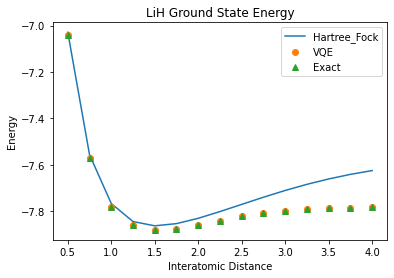

In [19]:
 pylab.plot(distances,hf_energies, label='Hartree_Fock')
 pylab.plot(distances, vqe_energies, 'o', label='VQE')
 pylab.plot(distances, exact_energies, '^', label='Exact')

 pylab.xlabel('Interatomic Distance')
 pylab.ylabel('Energy')
 pylab.title('LiH Ground State Energy')
 pylab.legend()